# Treinamento de Rede Neural com Tensorflow para análise do sinal

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from libs.commpy_mod import SISOFlatChannel

from files_01_detection.const_mod import generate_symbols, Model
from files_01_detection.const_analyzer import plot_decision_boundary, theoretical_ser, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

2022-12-11 22:38:51.211520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 22:38:52.319297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-11 22:38:52.319336: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-11 22:38:52.452378: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-11 22:38:57.008938: W tensorflow/stream_executor/platform/de

## Definição e transmissão do sinal pelo canal

In [2]:
Mod = 'PSK'
channel_type = 'rayleigh' # 'awgn' or 'crazy'
M            = 8      # PSK modulation
total_num_symbols  = 1000000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.5 # Fraction of whole data to be used for training (the remaining is for testing)
SNR_dB       = 15      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

In [3]:
#plot theoretical symbol error probability (SER) for this SNR
Pe = theoretical_ser(Mod, M, SNR_dB, channel_type, Es)
print("Theoretical symbol error probability (SER) =", Pe*100, "% for SNR =", SNR_dB,"dB")

Theoretical symbol error probability (SER) = 3.4155801424019416 % for SNR = 15 dB


In [4]:
symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB)

In [9]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = np.append(np.array([[]]), indices[:train_size])
X_train = np.stack([np.real(channel_output[:train_size]),
                    np.imag(channel_output[:train_size])], axis=1)

# Test
y_test = np.append(np.array([[]]), indices[train_size:])
X_test = np.stack([np.real(channel_output[train_size:]),
                   np.imag(channel_output[train_size:])], axis=1)

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

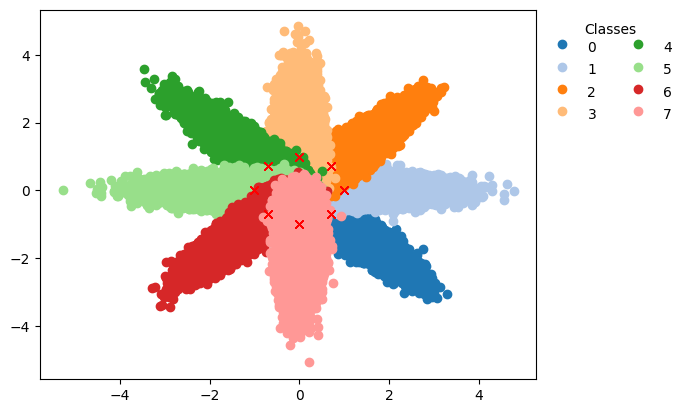

In [10]:
plot_symbols(X_train, y_train, M, symbs)

## Criação e treinamento da Rede Neural

In [11]:
n_inputs = np.shape(X_train)[1]
n_hidden1 = 100
n_hidden2 = 80
n_hidden3 = 50

n_outputs = M
learning_rate = 0.001
n_epochs = 100
batch_size = 5000

y_train = tf.reshape(tf.convert_to_tensor(y_train), [-1, 1])
y_test = tf.reshape(tf.convert_to_tensor(y_test), [-1, 1])
X_test = tf.convert_to_tensor(X_test)
X_train = tf.convert_to_tensor(X_train)

### Usando API Keras

In [12]:
inputs = tf.keras.Input(shape=(2,))

x = tf.keras.layers.Dense(n_hidden1, activation="relu", kernel_initializer="glorot_normal")(inputs)
x = tf.keras.layers.Dense(n_hidden2, activation="relu", kernel_initializer="glorot_normal")(x)
x = tf.keras.layers.Dense(n_hidden3, activation="relu", kernel_initializer="glorot_normal")(x)

output = tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x)

modelK = tf.keras.Model(inputs=inputs, outputs=output)

modelK.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 100)               300       
                                                                 
 dense_3 (Dense)             (None, 80)                8080      
                                                                 
 dense_4 (Dense)             (None, 50)                4050      
                                                                 
 dense_5 (Dense)             (None, 8)                 408       
                                                                 
Total params: 12,838
Trainable params: 12,838
Non-trainable params: 0
_________________________________________________________________


In [13]:
modelK.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
             metrics=["accuracy"])

history = modelK.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, shuffle=True)

tests_score = modelK.evaluate(X_test, y_test)
print("Test loss:", tests_score[0])
print("Test accuracy:", tests_score[1])
print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}")

Epoch 1/100
100/100 [==============================] - 4s 21ms/step - loss: 2.0745 - accuracy: 0.1490
Epoch 2/100
100/100 [==============================] - 2s 21ms/step - loss: 2.0590 - accuracy: 0.2709
Epoch 3/100
100/100 [==============================] - 2s 18ms/step - loss: 2.0451 - accuracy: 0.3447
Epoch 4/100
100/100 [==============================] - 2s 18ms/step - loss: 2.0324 - accuracy: 0.3824
Epoch 5/100
100/100 [==============================] - 2s 17ms/step - loss: 2.0206 - accuracy: 0.4159
Epoch 6/100
100/100 [==============================] - 2s 18ms/step - loss: 2.0094 - accuracy: 0.4597
Epoch 7/100
100/100 [==============================] - 2s 18ms/step - loss: 1.9981 - accuracy: 0.5245
Epoch 8/100
100/100 [==============================] - 2s 18ms/step - loss: 1.9865 - accuracy: 0.5581
Epoch 9/100
100/100 [==============================] - 2s 18ms/step - loss: 1.9745 - accuracy: 0.5719
Epoch 10/100
100/100 [==============================] - 2s 18ms/step - loss: 1.962

2022-12-11 22:43:40.118095: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 200000000 exceeds 10% of free system memory.
2022-12-11 22:43:40.269882: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 200000000 exceeds 10% of free system memory.
2022-12-11 22:43:40.608105: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 200000000 exceeds 10% of free system memory.
2022-12-11 22:43:40.863049: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 160000000 exceeds 10% of free system memory.
2022-12-11 22:43:41.003279: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 160000000 exceeds 10% of free system memory.


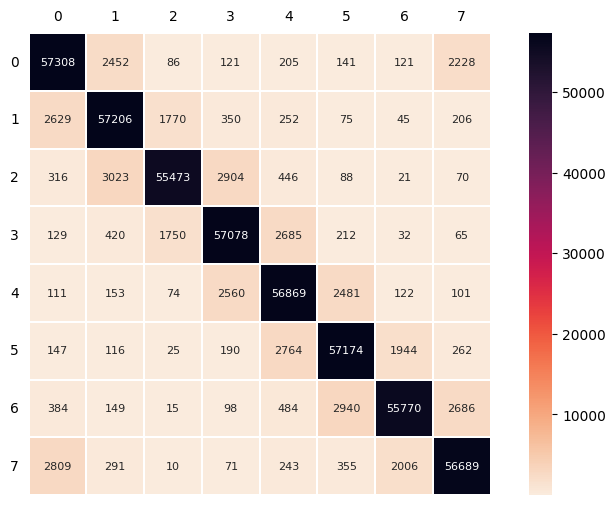

8


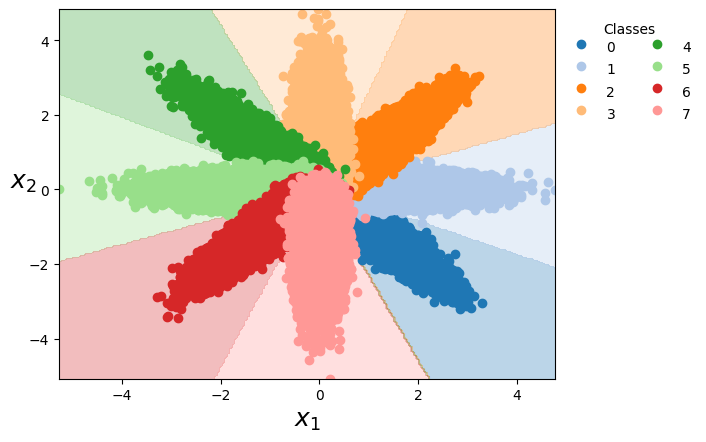

In [14]:
plot_confusion_matrix(modelK, X_test, y_test, M, nn=True)
plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True)